**Full Name:** Athanasios Chouklis

**SRN:** 10396

**Email:** cathanasd@ece.auth.gr


Department of Electrical and Computer Engineering, Aristotle University of Thessaloniki




**First Assignment in Neural Networks - Deep Learning**


During the intermediate assignment, we used some basic machine learning classifiers on the CIFAR-10 image database. Although our results were better than random chance, they were not satisfactory.

In this assignment we will attempt to do the same task using neural networks while following a **model-driven** approach. We will use the data as it is given, without modifying it except for range-scaling to [0,1]. As with the previous assignment, we will utilize the PyTorch deep learning framework in order to make use of its native support of AMD's ROCm for GPU acceleration.

We will begin by importing the necessary dependencies.

In [421]:
# Import PyTorch
import torch
from torch import nn

# Import PyTorch DataLoader and Learning Rate Scheduler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms.functional import rgb_to_grayscale

#Import torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Import timer to time our models
from timeit import default_timer as timer

# Import Dict and List for metrics plotting
from typing import Dict, List

# Import random for the creation of a random sample
import random

Let's also setup device agnostic code and set a random seed, for reproducibility.

In [354]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

torch.manual_seed(36)
torch.cuda.manual_seed(36)

Next, we will load our database and organize it into batches. The training data is shuffled to add an extra layer of randomness.

In [355]:
# Setup training data
train_data = datasets.CIFAR10(
    root="data", # data download location
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, which we will turn into Torch tensors
    target_transform=None # option to transform labels as well
)

# Setup testing data
test_data = datasets.CIFAR10(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # number of samples per batch
    shuffle=True # option to shuffle data every epoch
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

Files already downloaded and verified
Files already downloaded and verified


Let's have a look at some random samples of the database to get an idea of the kinds of images we are working with.

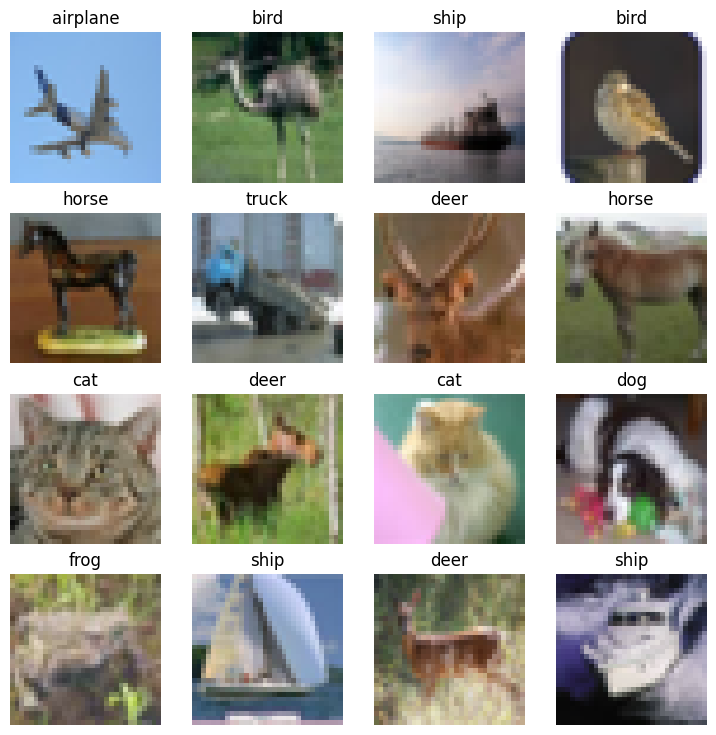

In [398]:
class_names = train_data.classes

random_idx = {}

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx[i] = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx[i]]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False);

Now let's have a look at what the images would look like after grayscaling.

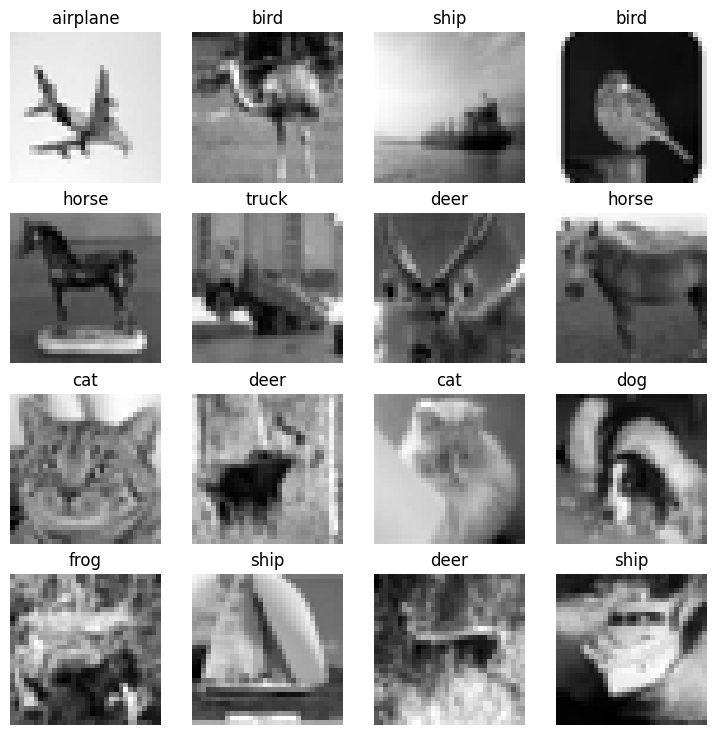

In [399]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    img, label = train_data[random_idx[i]]
    img = rgb_to_grayscale(img, 1).squeeze()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

Looking at the images, it would seem (intuitively) that omitting the process is actually beneficial, as the variety of the categories we are dealing with likely means that the information contained in the colors is critical for successful classification. Many of the above images appear difficult for even a human to make out without the presence of color information.

Now it's time to create functions for training and testing our models. Since we will be using many different ones, it makes sense to functionize the training and testing of them.

First we define the training function.

In [358]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               scheduler: torch.optim.lr_scheduler._LRScheduler,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward (backpropagation)
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    if scheduler is not None:
        scheduler.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    # Return metrics
    return train_loss, train_acc

And now the testing function.

In [359]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred,y)
        
        # Calculate loss and accuracy per epoch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        # Return metrics
        return test_loss, test_acc

We will also need a function that handles plotting loss and accuracy curves.

In [360]:
def plot_metrics_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss_values = results['train_loss']
    test_loss_values = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy_values = results['train_acc']
    test_accuracy_values = results['test_acc']

    # Figure out how many epochs there were
    num_of_epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(num_of_epochs, loss_values, label='train_loss')
    plt.plot(num_of_epochs, test_loss_values, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(num_of_epochs, accuracy_values, label='train_accuracy')
    plt.plot(num_of_epochs, test_accuracy_values, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Finally, we will combine the above to create a training, testing, and results plotting function to avoid rewriting code.

In [361]:
def test_train_plot(model: torch.nn.Module,
               data_loader_train: torch.utils.data.DataLoader,
               data_loader_test: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               epochs,
               scheduler: torch.optim.lr_scheduler._LRScheduler):

    # Create a results dictionary to store the metrics
    results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }

    # Start the timer
    start_time = timer()

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Training step
        train_loss, train_acc = train_step(data_loader=data_loader_train, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            scheduler=scheduler
        )
        
        #Testing step
        test_loss, test_acc = test_step(data_loader=data_loader_test,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
        )
        
        # Print out the loss and accuracy
        if epochs == 51:
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}\n---------")
                print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")
        if epochs == 101:
            if epoch % 20 == 0:
                print(f"Epoch: {epoch}\n---------")
                print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")
        
        # Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage and plotting
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")

    plot_metrics_curves(results)

We are now ready to start training and testing models. The first model we will use is a very basic 2-layer linear neural network, which we will consider our barebones baseline model.

We will start with a small number of epochs (3) to test the waters without wasting too much time in case of obvious failure. For this reason, we will not utilize the function we created at first.

First we define it in the form of a `class`, as we will do with every model.

In [362]:
class BaselineModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # turn the input into an array of three vectors, one for each color channel
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (3072 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

Then we create an instance of it, set our optimizer and loss function, and choose the metric we will use to keep track of performance per epoch.

The loss function chosen is `CrossEntropyLoss`, while the optimizer is `SGD` (Stochastic Gradient Descent).

The metric we will use to track performance is accuracy, using the `MulticlassAccuracy` function from `torchmetrics`.

In [363]:
# Setup model with input parameters
base_model = BaselineModel(input_shape=3072, # one for every pixel (32x32x3 = 3072)
    hidden_units=8, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = None

Finally, we create the training and testing loop.

In [364]:
# Set number of epohcs
epochs = 3

# Start the timer
start_time = timer()

# Training loop
for epoch in tqdm(range(epochs)):
    # Training step
    train_loss, train_acc = train_step(data_loader=train_dataloader, 
        model=base_model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=mca,
        scheduler=scheduler
    )
    
    #Testing step
    test_loss, test_acc = test_step(data_loader=test_dataloader,
        model=base_model,
        loss_fn=loss_fn,
        accuracy_fn=mca,
    )
    
    # Every epoch, print out the loss and accuracy
    print(f"Epoch: {epoch}\n---------")
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}%")
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n")

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 33%|███▎      | 1/3 [00:08<00:16,  8.33s/it]

Epoch: 0
---------
Train loss: nan | Train accuracy: 9.95%
Test loss: nan | Test accuracy: 10.00%



 67%|██████▋   | 2/3 [00:16<00:08,  8.30s/it]

Epoch: 1
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 10.00%



100%|██████████| 3/3 [00:24<00:00,  8.21s/it]

Epoch: 2
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 10.00%

Total training time: 24.620 seconds


We see that the accuracy value is almost exactly 10%, which means successful classification happens at the odds of random chance (given that we are dealing with 10 different classes, random chance is 1 in 10).

Interestingly, the loss values end up as NaN. This could be because a natural property of the stochastic gradient descent optimizer is that, if the learning rate is too large, it can diverge into infinity.

However, we can see that it happens instantly, whereas usually in this case the loss would gradually rise until it eventually surpasses the limit.

In any case, let's lower the learning rate and try again. This time we will take advantage of the function we created for easier setup.

  2%|▏         | 1/51 [00:08<06:48,  8.18s/it]

Epoch: 0
---------
Train loss: 1.97028 | Train accuracy: 29.21%
Test loss: 1.87249 | Test accuracy: 33.09%



 22%|██▏       | 11/51 [01:28<05:18,  7.95s/it]

Epoch: 10
---------
Train loss: 1.72554 | Train accuracy: 40.07%
Test loss: 1.75303 | Test accuracy: 38.19%



 41%|████      | 21/51 [02:47<03:58,  7.96s/it]

Epoch: 20
---------
Train loss: 1.69940 | Train accuracy: 41.32%
Test loss: 1.72739 | Test accuracy: 39.89%



 61%|██████    | 31/51 [04:07<02:39,  8.00s/it]

Epoch: 30
---------
Train loss: 1.68445 | Train accuracy: 42.19%
Test loss: 1.72770 | Test accuracy: 39.68%



 80%|████████  | 41/51 [05:26<01:18,  7.88s/it]

Epoch: 40
---------
Train loss: 1.67683 | Train accuracy: 42.44%
Test loss: 1.76101 | Test accuracy: 38.63%



100%|██████████| 51/51 [06:45<00:00,  7.95s/it]

Epoch: 50
---------
Train loss: 1.66914 | Train accuracy: 42.78%
Test loss: 1.74973 | Test accuracy: 39.53%

Total training time: 405.302 seconds


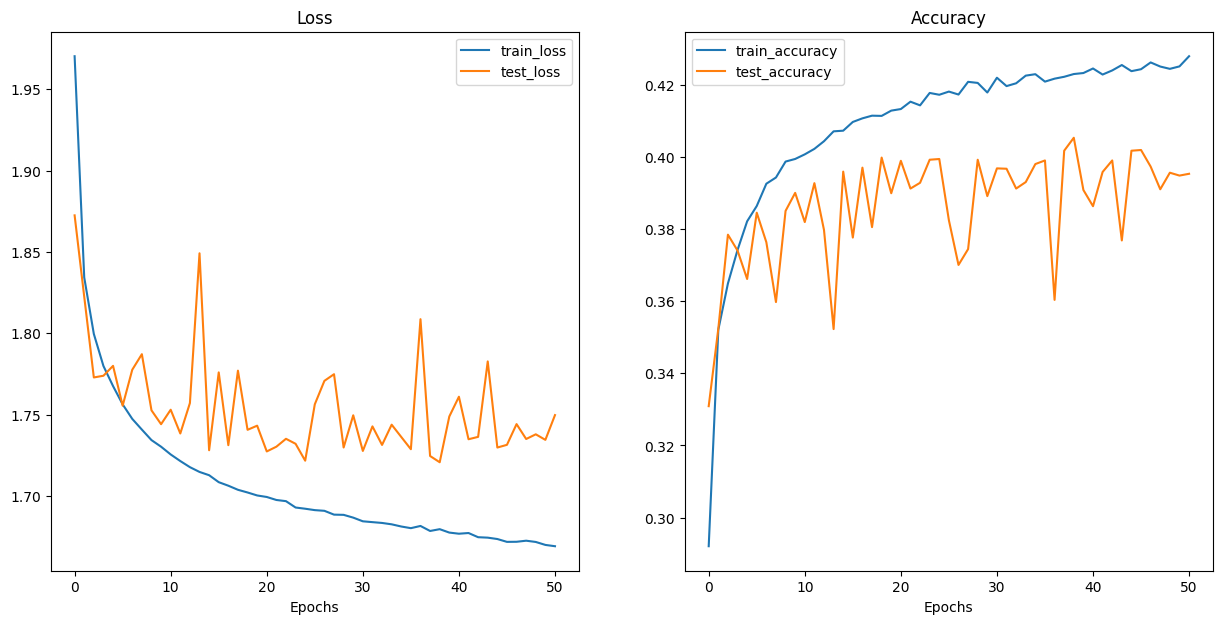

In [ ]:
# Setup model with input parameters
base_model = BaselineModel(input_shape=3072, # one for every pixel (32x32x3 = 3072)
    hidden_units=8, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.01)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = None

# Set number of epochs
epochs = 51

test_train_plot(model=base_model,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

It turns out the learning rate was the culprit. Lowering it by an order of magnitude appears to have fixed the issue: after 51 epochs our model reaches a train/test accuracy that hovers around 40%, with the training accuracy being larger (overfitting).

For a purely linear neural network, a very respectable result. Now let's see if adding some non-linearity to the model improves our results.

We will simply add a `ReLU` layer (element-wise rectified linear unit activation function) after each `Linear` layer and go from there.

In [366]:
class BasicNonLinearModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # turn the input into an array of three vectors, one for each color channel
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (3072 pixels)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

The setup, training and testing process is identical, so we will not touch on it again with the exception of pointing out explicit changes.

  2%|▏         | 1/51 [00:08<06:40,  8.01s/it]

Epoch: 0
---------
Train loss: 2.14227 | Train accuracy: 22.80%
Test loss: 1.98429 | Test accuracy: 29.35%



 22%|██▏       | 11/51 [01:27<05:19,  7.98s/it]

Epoch: 10
---------
Train loss: 1.73781 | Train accuracy: 38.45%
Test loss: 1.73547 | Test accuracy: 38.27%



 41%|████      | 21/51 [02:46<03:57,  7.90s/it]

Epoch: 20
---------
Train loss: 1.68920 | Train accuracy: 40.35%
Test loss: 1.75413 | Test accuracy: 38.44%



 61%|██████    | 31/51 [04:06<02:41,  8.09s/it]

Epoch: 30
---------
Train loss: 1.65660 | Train accuracy: 41.77%
Test loss: 1.71030 | Test accuracy: 39.64%



 80%|████████  | 41/51 [05:26<01:19,  7.95s/it]

Epoch: 40
---------
Train loss: 1.63547 | Train accuracy: 42.23%
Test loss: 1.77412 | Test accuracy: 37.17%



100%|██████████| 51/51 [06:46<00:00,  7.97s/it]

Epoch: 50
---------
Train loss: 1.62103 | Train accuracy: 42.76%
Test loss: 1.64900 | Test accuracy: 41.67%

Total training time: 406.572 seconds


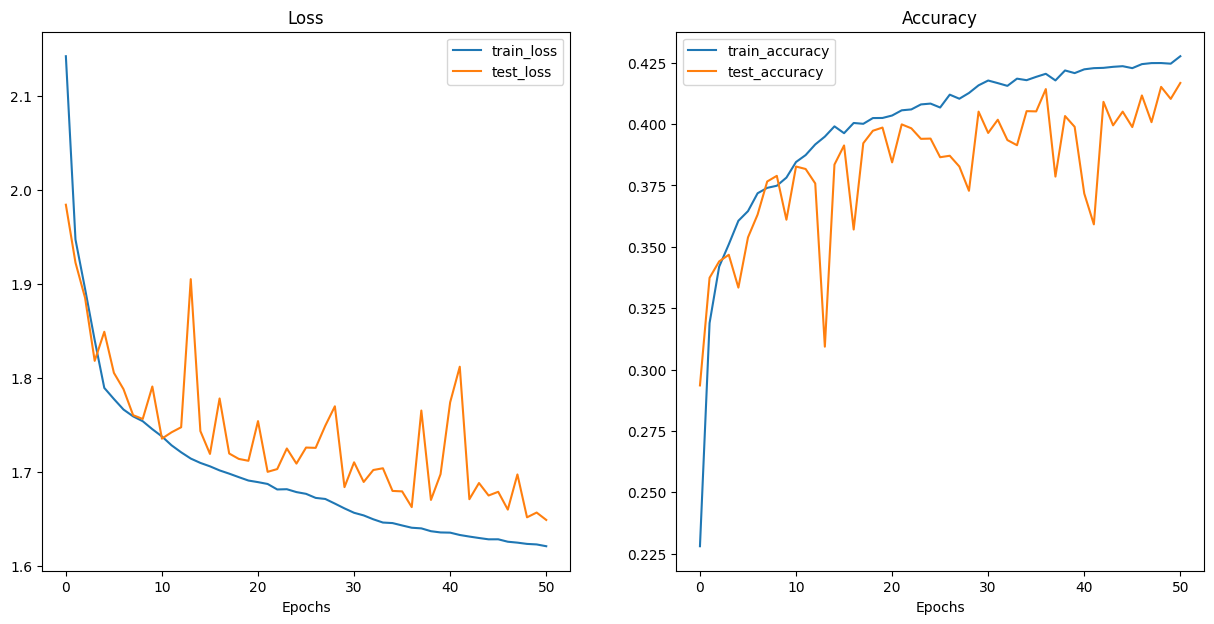

In [ ]:
# Setup model with input parameters
basic_nonlinear_model = BasicNonLinearModel(input_shape=3072, # one for every pixel (32x32x3 = 3072)
    hidden_units=8, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=basic_nonlinear_model.parameters(), lr=0.01)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = None

# Set number of epochs
epochs = 51

test_train_plot(model=basic_nonlinear_model,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

We have some improvement. The train/test accuracy scores now appear to be closer to 42%, and the difference between them has diminished by around 2%. Despite the increase in complexity, the execution time is nearly identical.

Let's see if doubling the number of hidden units can increase the performance.

  2%|▏         | 1/51 [00:08<06:54,  8.30s/it]

Epoch: 0
---------
Train loss: 2.14626 | Train accuracy: 23.10%
Test loss: 2.07998 | Test accuracy: 25.99%



 22%|██▏       | 11/51 [01:29<05:26,  8.17s/it]

Epoch: 10
---------
Train loss: 1.64402 | Train accuracy: 42.20%
Test loss: 1.68736 | Test accuracy: 40.25%



 41%|████      | 21/51 [02:51<04:04,  8.14s/it]

Epoch: 20
---------
Train loss: 1.56201 | Train accuracy: 44.80%
Test loss: 1.59044 | Test accuracy: 43.63%



 61%|██████    | 31/51 [04:12<02:42,  8.14s/it]

Epoch: 30
---------
Train loss: 1.51874 | Train accuracy: 46.29%
Test loss: 1.62218 | Test accuracy: 42.38%



 80%|████████  | 41/51 [05:33<01:20,  8.07s/it]

Epoch: 40
---------
Train loss: 1.48850 | Train accuracy: 47.52%
Test loss: 1.56335 | Test accuracy: 44.19%



100%|██████████| 51/51 [06:54<00:00,  8.13s/it]

Epoch: 50
---------
Train loss: 1.47317 | Train accuracy: 47.77%
Test loss: 1.55890 | Test accuracy: 44.10%

Total training time: 414.803 seconds


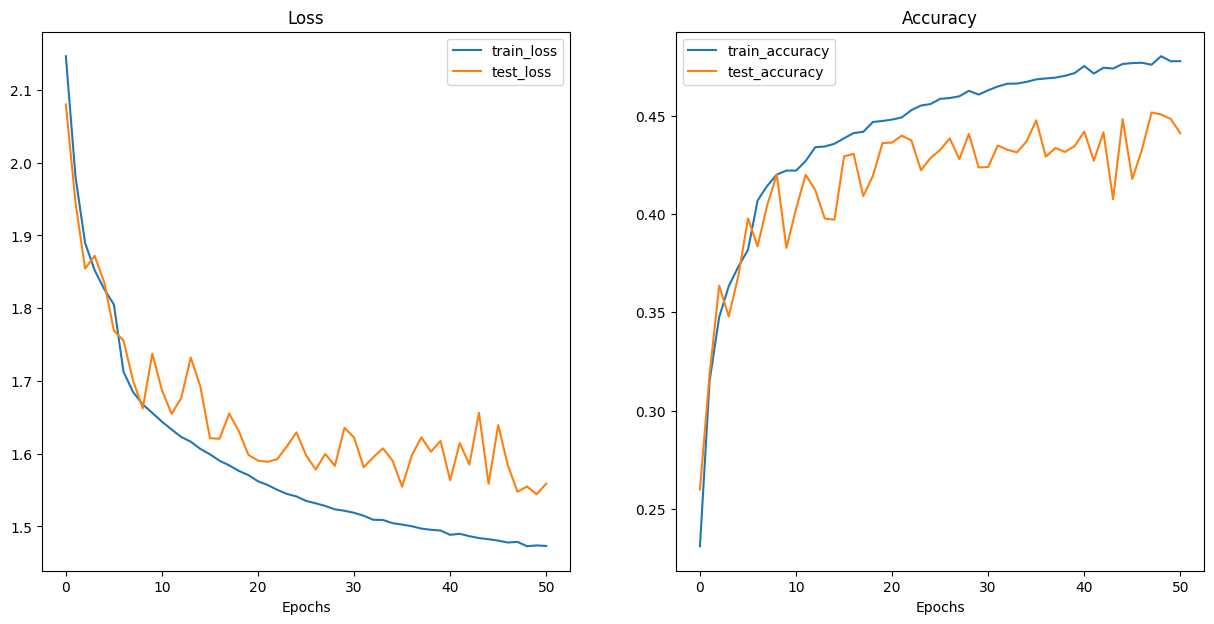

In [ ]:
# Setup model with input parameters
basic_nonlinear_model = BasicNonLinearModel(input_shape=3072, # one for every pixel (32x32x3 = 3072)
    hidden_units=16, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=basic_nonlinear_model.parameters(), lr=0.01)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = None

# Set number of epochs
epochs = 51

test_train_plot(model=basic_nonlinear_model,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

Our model's training and testing accuracy have improved by ~5% and ~2% respectively. It therefore performs better but overfitting is worse. The computation time was marginally increased but remains very close to the previous one.

Before attempting to combat it with specific techniques, we will try to add a few more layers, specifically another `Linear` / `ReLU` pair and see how it performs.

In [374]:
class BasicMLP(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (3072 pixels)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units), 
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

  2%|▏         | 1/51 [00:08<07:05,  8.50s/it]

Epoch: 0
---------
Train loss: 2.13572 | Train accuracy: 23.61%
Test loss: 2.05230 | Test accuracy: 27.96%



 22%|██▏       | 11/51 [01:32<05:37,  8.43s/it]

Epoch: 10
---------
Train loss: 1.61954 | Train accuracy: 42.41%
Test loss: 1.64091 | Test accuracy: 41.57%



 41%|████      | 21/51 [02:56<04:11,  8.39s/it]

Epoch: 20
---------
Train loss: 1.53492 | Train accuracy: 45.46%
Test loss: 1.57839 | Test accuracy: 44.45%



 61%|██████    | 31/51 [04:20<02:47,  8.38s/it]

Epoch: 30
---------
Train loss: 1.48580 | Train accuracy: 47.13%
Test loss: 1.53533 | Test accuracy: 45.47%



 80%|████████  | 41/51 [05:44<01:24,  8.42s/it]

Epoch: 40
---------
Train loss: 1.45352 | Train accuracy: 48.29%
Test loss: 1.61879 | Test accuracy: 42.16%



100%|██████████| 51/51 [07:07<00:00,  8.39s/it]

Epoch: 50
---------
Train loss: 1.43153 | Train accuracy: 48.92%
Test loss: 1.54309 | Test accuracy: 44.98%

Total training time: 427.829 seconds


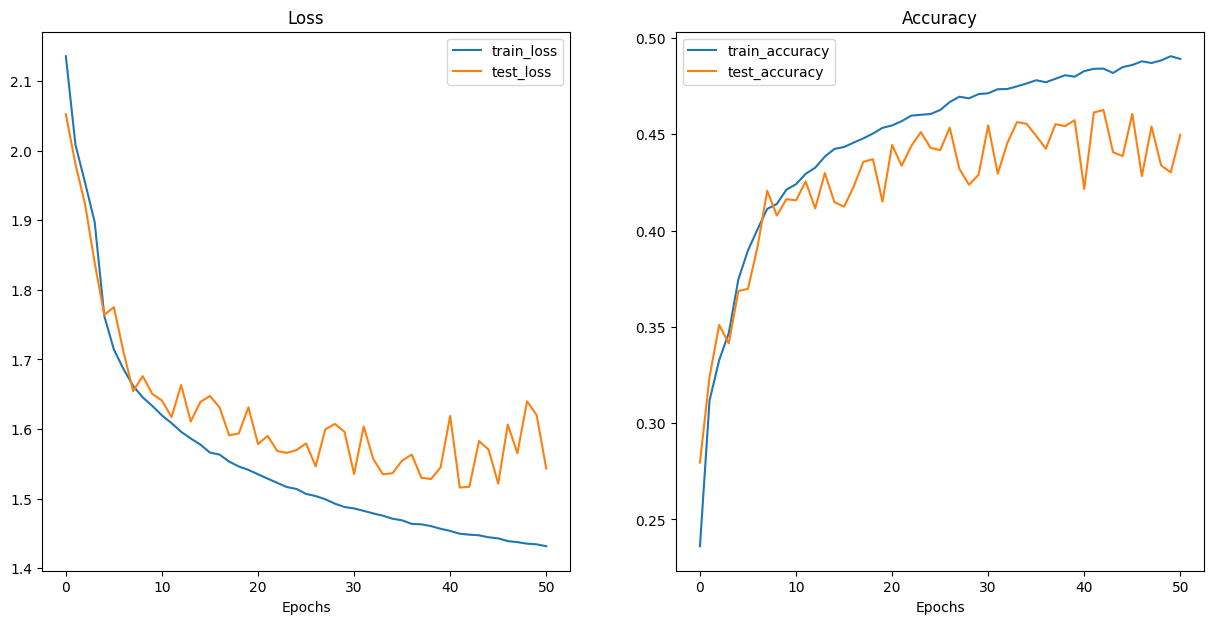

In [ ]:
# Setup model with input parameters
MLP_model = BasicMLP(input_shape=3072, # one for every pixel (32x32x3 = 3072)
    hidden_units=16, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=MLP_model.parameters(), lr=0.01)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = None

# Set number of epochs
epochs = 51

test_train_plot(model=MLP_model,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

Both the training and the testing accuracies have increased by 1%. The execution time has increased by around 13 seconds.

We can clearly observe that there is still overfitting.

There are a few more changes we can make without radically changing the model. We will test the impact of Dropout layers, as well as a Scheduler to adjust the learning rate on-the-fly.

We will begin by adding a scheduler, in an attempt to accelerate training progress by starting with a larger learning rate and gradually decreasing it every epoch. For this we will use `ExponentialLR` with a gamma value of `0.9`. The starting learning rate will be `0.1`.

  2%|▏         | 1/51 [00:08<06:56,  8.33s/it]

Epoch: 0
---------
Train loss: 2.16673 | Train accuracy: 21.88%
Test loss: 2.06192 | Test accuracy: 27.63%



 22%|██▏       | 11/51 [01:31<05:29,  8.25s/it]

Epoch: 10
---------
Train loss: 1.69595 | Train accuracy: 39.46%
Test loss: 1.68740 | Test accuracy: 38.77%



 41%|████      | 21/51 [02:55<04:11,  8.39s/it]

Epoch: 20
---------
Train loss: 1.58226 | Train accuracy: 43.45%
Test loss: 1.61697 | Test accuracy: 41.76%



 61%|██████    | 31/51 [04:19<02:48,  8.41s/it]

Epoch: 30
---------
Train loss: 1.53300 | Train accuracy: 45.11%
Test loss: 1.57813 | Test accuracy: 42.72%



 80%|████████  | 41/51 [05:43<01:23,  8.40s/it]

Epoch: 40
---------
Train loss: 1.51340 | Train accuracy: 45.86%
Test loss: 1.56539 | Test accuracy: 43.28%



100%|██████████| 51/51 [07:06<00:00,  8.37s/it]

Epoch: 50
---------
Train loss: 1.50637 | Train accuracy: 46.13%
Test loss: 1.56180 | Test accuracy: 43.63%

Total training time: 426.633 seconds


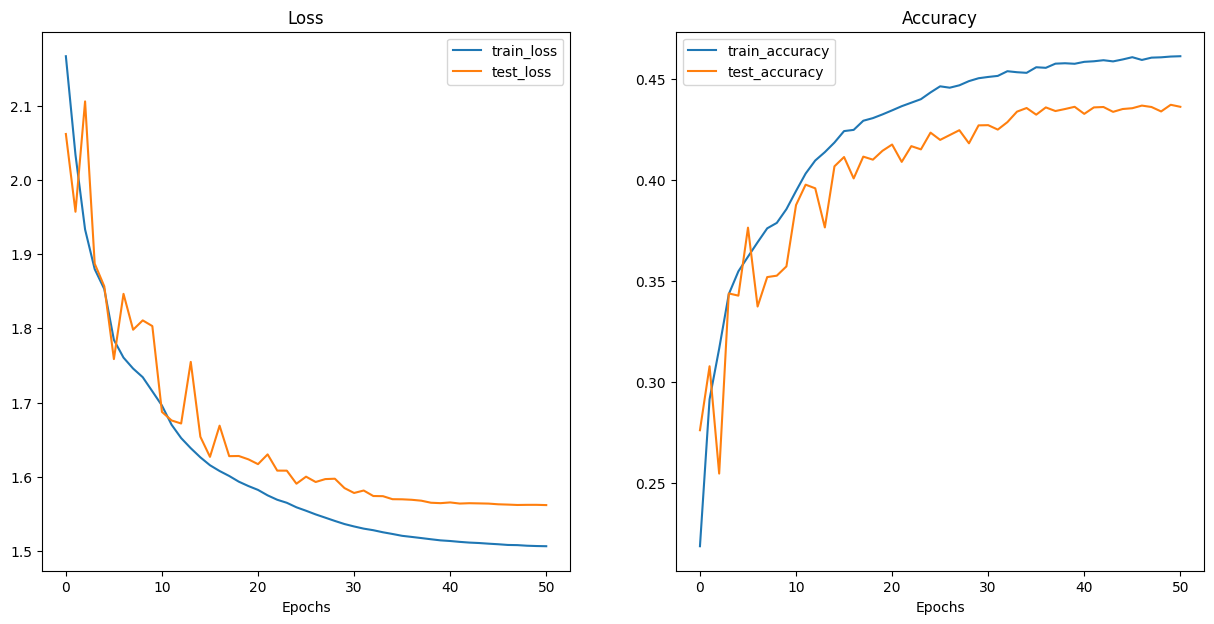

In [ ]:
# Setup model with input parameters
MLP_model = BasicMLP(input_shape=3072, # one for every pixel (32x32x3 = 3072)
    hidden_units=16, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=MLP_model.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 51

test_train_plot(model=MLP_model,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

The model performs slightly worse, but the test_loss and test_accuracy curves are much smoother than before. The presence of the scheduler has added stability to the system. Execution time has not increased, and overfitting has decreased slightly.

Overall, it appears to have had a positive impact.

Next we will test the impact of Dropout layers. This should theoretically help with overfitting.

In [381]:
class BasicMLP(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (3072 pixels)
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=hidden_units, out_features=hidden_units), 
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

  2%|▏         | 1/51 [00:08<07:03,  8.48s/it]

Epoch: 0
---------
Train loss: 2.15774 | Train accuracy: 17.41%
Test loss: 2.10441 | Test accuracy: 20.32%



 22%|██▏       | 11/51 [01:32<05:36,  8.40s/it]

Epoch: 10
---------
Train loss: 1.65434 | Train accuracy: 40.20%
Test loss: 1.67576 | Test accuracy: 39.52%



 41%|████      | 21/51 [02:57<04:12,  8.41s/it]

Epoch: 20
---------
Train loss: 1.56517 | Train accuracy: 43.69%
Test loss: 1.59854 | Test accuracy: 42.59%



 61%|██████    | 31/51 [04:20<02:46,  8.35s/it]

Epoch: 30
---------
Train loss: 1.53431 | Train accuracy: 44.78%
Test loss: 1.58056 | Test accuracy: 43.35%



 80%|████████  | 41/51 [05:44<01:23,  8.39s/it]

Epoch: 40
---------
Train loss: 1.52234 | Train accuracy: 45.33%
Test loss: 1.57011 | Test accuracy: 44.05%



100%|██████████| 51/51 [07:07<00:00,  8.39s/it]

Epoch: 50
---------
Train loss: 1.51794 | Train accuracy: 45.52%
Test loss: 1.57042 | Test accuracy: 44.18%

Total training time: 427.665 seconds


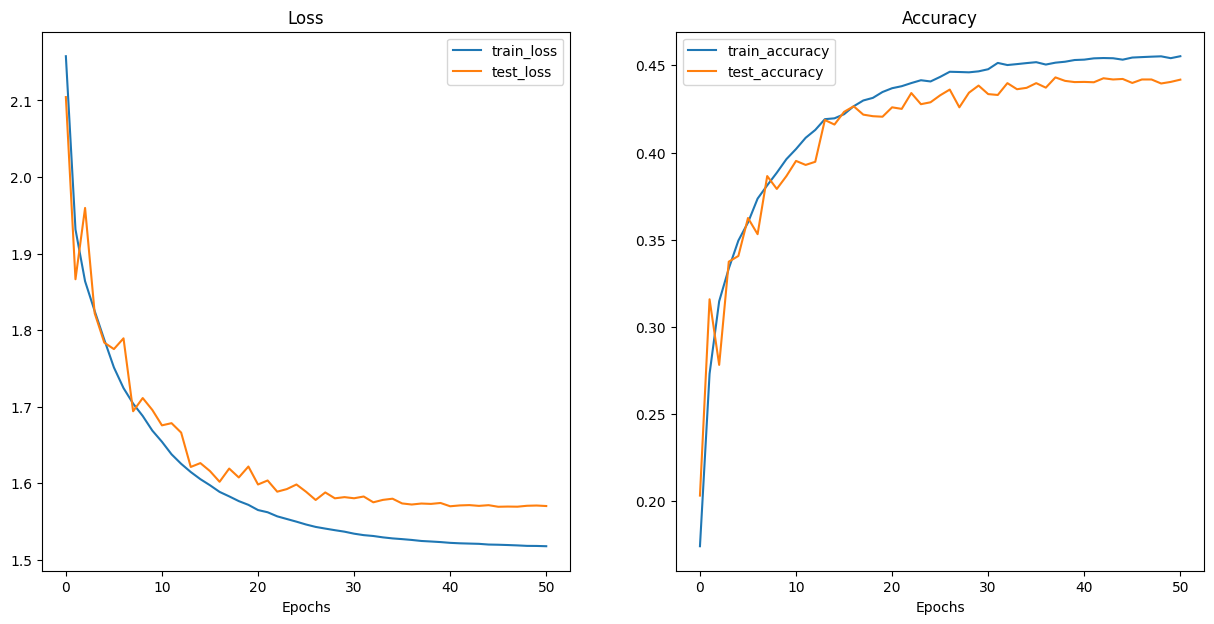

In [ ]:
# Setup model with input parameters
MLP_model = BasicMLP(input_shape=3072, # one for every pixel (32x32x3 = 3072)
    hidden_units=16, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=MLP_model.parameters(), lr=0.1)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Set number of epochs
epochs = 51

test_train_plot(model=MLP_model,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

The performance of our model has increased and overfitting has become less pronounced, at the cost of negligibly increased execution time. Overall, a success.

In an attempt to further increase the performance of our model, we will switch to a **convolutional neural network**, as they are known to produce good results for image classification.

The following page constitutes a very helpful interactive visual resource for understanding the way convolutional neural networks work: https://poloclub.github.io/cnn-explainer/.

The architecture used here is a more-or-less direct PyTorch implementation of TinyVGG as shown and explained in the above resource, with the addition of a Droupout layer after every `ReLU` layer.

In [417]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # size of the square that's going over the image
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # The in_features shape below is derived from the way each layer of the network compresses and changes the shape of the input data. 
            nn.Linear(in_features=hidden_units*8*8, # the way we arrive at the 8*8 figure is explained below
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):

        # This way of computing the forward pass is less efficient than the one below it, due to operator fusion.
        # But, we can use it during our first run in order to place print statements after every layer and see the shape of the output,
        # which we can then use to define the in_features parameter above.
        #x = self.conv_block_1(x)
        # print(x.shape)
        #x = self.conv_block_2(x)
        # print(x.shape)
        #x = self.classifier(x)
        # print(x.shape)
        #return x

        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

  2%|▏         | 1/51 [00:08<06:42,  8.06s/it]

Epoch: 0
---------
Train loss: 2.13263 | Train accuracy: 21.26%
Test loss: 1.98245 | Test accuracy: 29.71%



 22%|██▏       | 11/51 [01:24<05:07,  7.70s/it]

Epoch: 10
---------
Train loss: 1.25301 | Train accuracy: 55.63%
Test loss: 1.29263 | Test accuracy: 52.83%



 41%|████      | 21/51 [02:42<03:51,  7.71s/it]

Epoch: 20
---------
Train loss: 1.04062 | Train accuracy: 63.61%
Test loss: 1.08174 | Test accuracy: 61.81%



 61%|██████    | 31/51 [03:59<02:34,  7.72s/it]

Epoch: 30
---------
Train loss: 0.91259 | Train accuracy: 68.27%
Test loss: 1.04465 | Test accuracy: 63.86%



 80%|████████  | 41/51 [05:17<01:17,  7.71s/it]

Epoch: 40
---------
Train loss: 0.85252 | Train accuracy: 70.46%
Test loss: 0.98524 | Test accuracy: 66.09%



100%|██████████| 51/51 [06:34<00:00,  7.73s/it]

Epoch: 50
---------
Train loss: 0.81171 | Train accuracy: 71.65%
Test loss: 0.96688 | Test accuracy: 66.54%

Total training time: 394.153 seconds


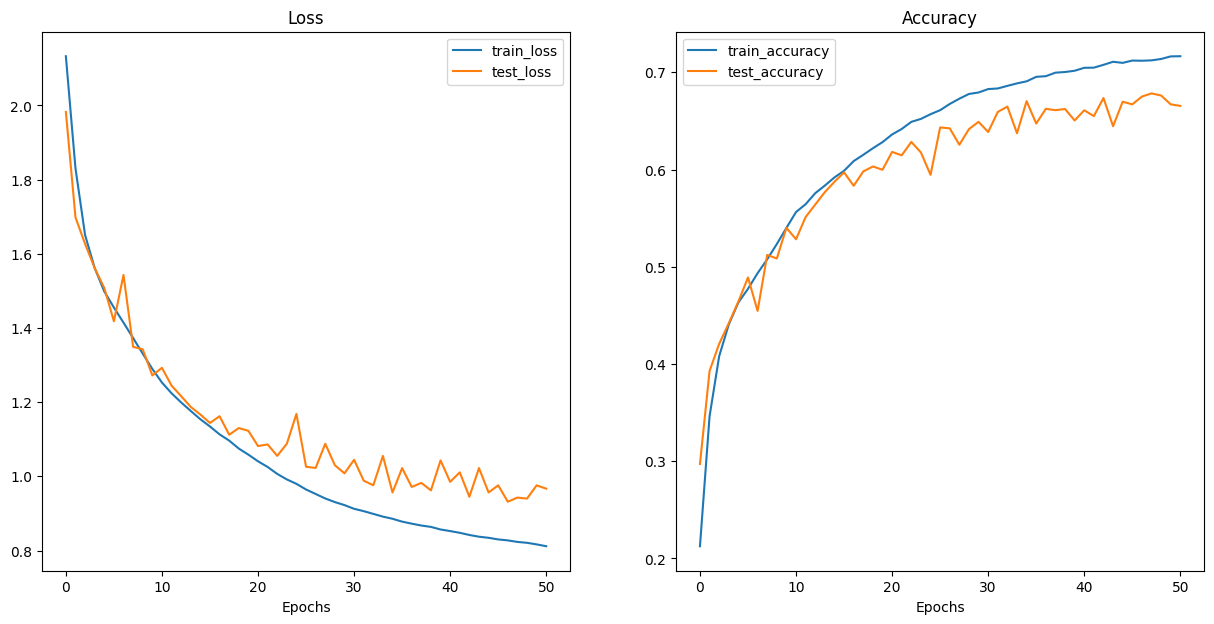

In [ ]:
# Setup model with input parameters
CNNModel = TinyVGG(input_shape=3, # one for every color channel
    hidden_units=10, # number of units in the hidden layer
    output_shape=len(class_names) # one for every class
).to(device)

# Setup optimizer
optimizer = torch.optim.SGD(params=CNNModel.parameters(), lr=0.01)

# Setup accuracy function
mca = MulticlassAccuracy(num_classes=10, average='micro').to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup scheduler
scheduler = None

# Set number of epochs
epochs = 51

test_train_plot(model=CNNModel,
               data_loader_train=train_dataloader,
               data_loader_test=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=mca,
               epochs=epochs,
               scheduler=scheduler)

The CNN model performs **markedly** better than the MLP, boasting a ~**22%** (!) accuracy increase for *less* computation time - about half a minute faster. Overfitting is worse, but the model performs better overall.


In general, when compared to the results of the previous assignment, which were:

**1-NN**: 35.4%

**3-NN**: 33.02%

**Nearest Centroid**: 27.74%,

both the MLP and the CNN surpass the highest-performing of the previous classifiers (1-NN). The MLP has a **10%** accuracy lead and the CNN a **32%** one, although both are much more computationally expensive, as the runtime of all the simpler classifiers *combined* was approximately 4 seconds (ran on the GPU), whereas their neural network counterparts take several minutes each.

To finish, we will look at some examples of classification on a random sample of images, using our final best-performing MLP and CNN models (test accuracy wise). To do this, we first define a function that makes predictions on a sample of data.

In [419]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Now we create a random sample, make predictions on it, and view them.

First with the MLP.

Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 2 (bird)


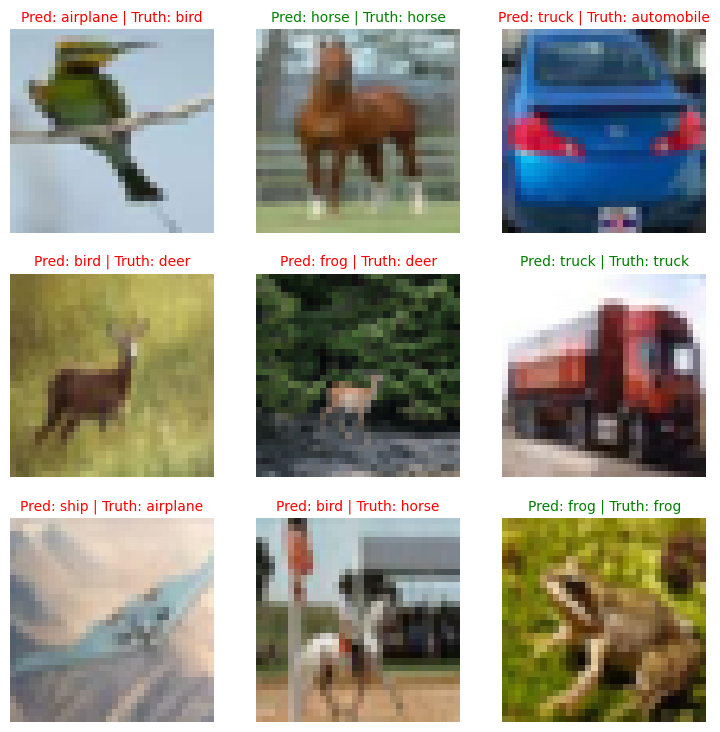

In [431]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

pred_probs= make_predictions(model=MLP_model, 
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form)
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

The first picture could *perhaps* be mistaken for an airplane based on the shape of the bird's body - but the beak and the twig should have been dead giveaways.

In the third picture, the car has been falsely classified as a truck; although they are both road vehicles, the lower height of the car should again have been a sufficient clue.

On to the middle row, the first deer picture is not confusing enough to be falsely classified, however the second one, due to the small size of the deer in comparison to the background, is understandable in its false classification as a frog.

On to the last row, it could be argued that for the first image the background could be mistaken for ocean waves, and the shape of the airplane would then match with that of a "stereotypical" ship.

The second picture of the last row does not appear to have any such explanation.

Now the CNN.

Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 2 (bird)


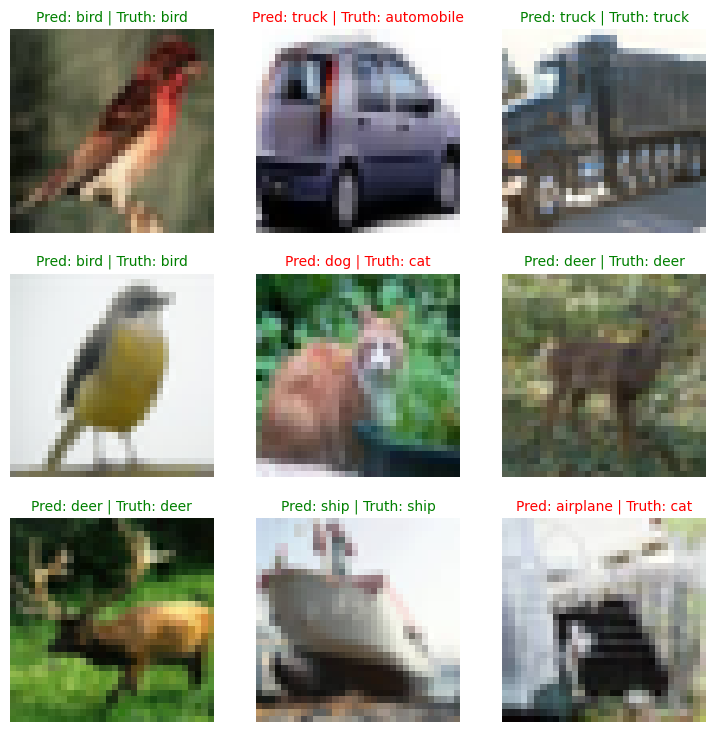

In [ ]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

pred_probs= make_predictions(model=CNNModel, 
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form)
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Similar to before, a car has been mistaken for a truck. This time, however, it is a taller car, and therefore it is more understandable.

On the middle row, a cat has been falsely identified as a dog. As they are both pets sometimes of similar size, it's not unthinkable how this could occur.

Lastly, we have the false classification of a cat as a plane. Although the face should have been sufficient to avoid this, the point of confusion could perhaps be the triangular shape of the cat's body, excluding the head.

Overall, we have a higher success rate and the results are more explicable - the CNN model is clearly superior.


Resources and tools used:

**ROCm**

https://gist.githubusercontent.com/damico/484f7b0a148a0c5f707054cf9c0a0533/raw/43c317bfbde626d9112d44462d815613194988e0/test-rocm.py

https://rocm.docs.amd.com/projects/install-on-linux/en/develop/install/3rd-party/pytorch-install.html

https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/native-install/ubuntu.html


**Pytorch**

https://pytorch.org/

https://www.dataquest.io/blog/pytorch-for-beginners/


**The CIFAR-10 image database**

https://www.cs.toronto.edu/~kriz/cifar.html

Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
(https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)


**VSCode**

https://code.visualstudio.com/

GitHub Copilot was utilized.


**CNN explainer,  TinyVGG**

https://poloclub.github.io/cnn-explainer/

**Additional helpful information**

https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/

https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network